# データ取得と読み込み

1. pandasで読み込み
2. データ概要確認
    - 行数・期間：df.shape, df.index.min(), df.index.max()
	- 欠損値チェック：df.isna().sum()

Index(['Temperature'], dtype='object')
(3652, 1)
1981-01-01 00:00:00
1990-12-31 00:00:00
Temperature    2
dtype: int64


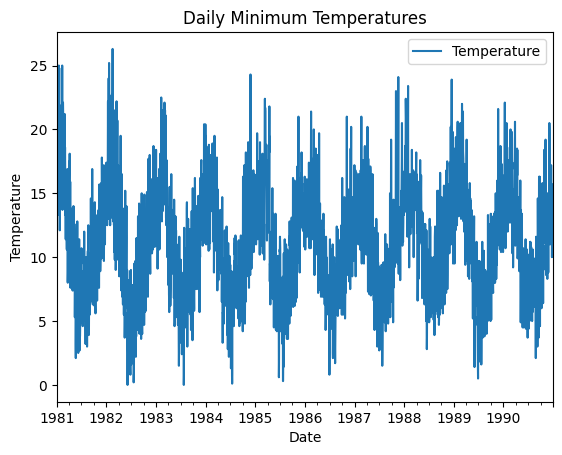

In [ ]:
import pandas as pd

df = pd.read_csv(
    "data/daily-minimum-temperatures-in-me.csv",
    parse_dates=["Date"],
    index_col="Date",
).rename(columns={
    'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'Temperature'
}).asfreq('D')

# 「?」を空文字に置き換え → 数値変換
df['Temperature'] = (
    df['Temperature']
      .str.replace(r'\?', '', regex=True)      # 「?」を削除
      .str.strip()                             # 前後空白を削除
      .replace('', pd.NA)                      # 空文字は欠損に
      .astype(float)                           # float にキャスト
)

df.plot(title='Daily Minimum Temperatures', xlabel='Date', ylabel='Temperature')

print(df.columns)
print(df.shape)
print(df.index.min())
print(df.index.max())
print(df.isna().sum())


# 前処理と可視化

1. 欠損値・重複の除去（必要なら）
2. 時系列プロット
3. 季節性・トレンド把握のための分解

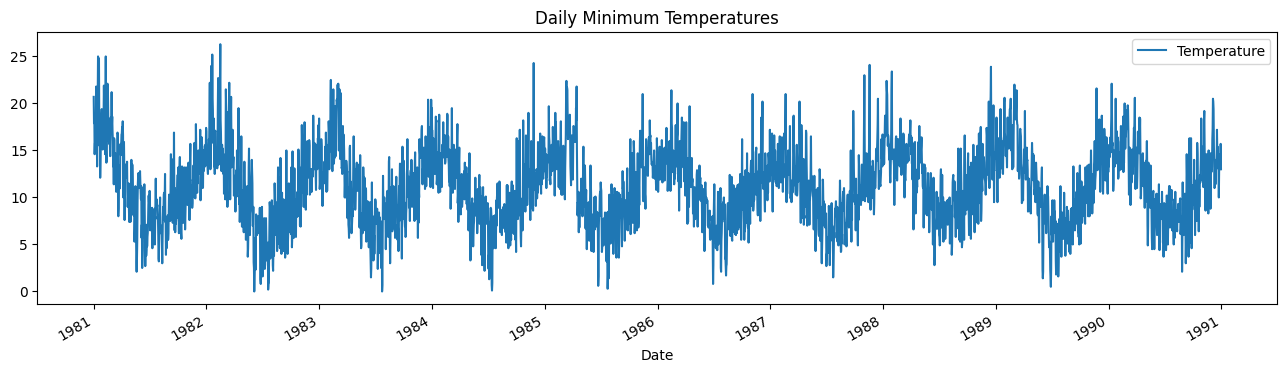

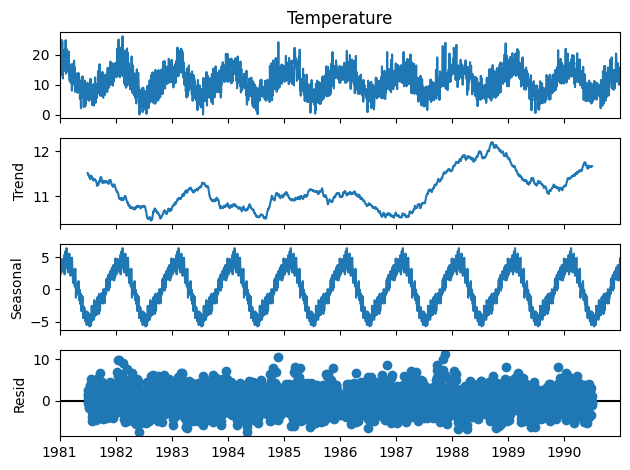

In [3]:
import matplotlib.pyplot as plt

df.plot(figsize=(16,4), title="Daily Minimum Temperatures")

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df['Temperature'], model="additive", period=365)
res.plot();


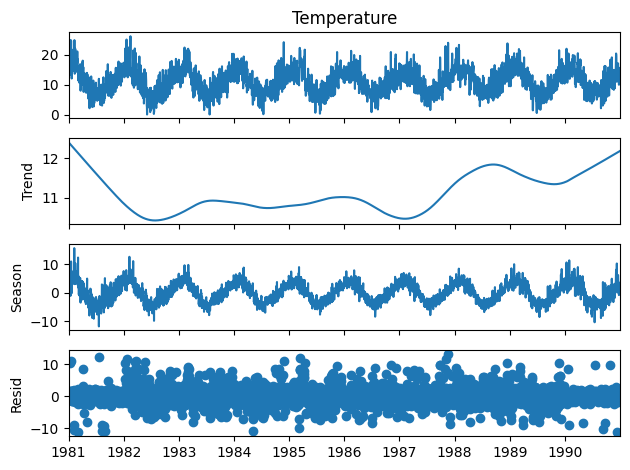

In [4]:

from statsmodels.tsa.seasonal import STL
stl = STL(df['Temperature'], period=365, robust=True)
stlres = stl.fit()

_ = stlres.plot()

# 年周期（period=365）の妥当性

- データの性質に合致

与えられたデータは「日次気温」で、季節（春夏秋冬）による変動が最も大きいため、period=365 は年１周期を捉える上で妥当です。グラフに現れているように、夏に向かって上昇し冬に向かって下降する山谷が毎年ほぼ同じタイミング・振幅で繰り返されており、季節成分（２番目のパネル）に明確な年周期パターンが抽出されています。

# 長期トレンドの解釈

トレンド成分（上から２番目のパネル）は「ローカル回帰（Loess）」によって滑らかに抽出されています。特徴としては：

1.	1981年～1982年初頭：緩やかな下降
    - 観測開始当初（1981年）の平均気温が約12.5℃程度から、翌年初めにかけて11℃弱まで落ち込んでいます。測定器の調整や観測地点の微妙な環境変化、あるいは気象的に冷夏／暖冬が続いた可能性が考えられます。
2. 1982年～1987年：概ね横ばい＋わずかな起伏
    - 年ごとの平均値はほぼ11℃台前半で安定しつつ、1983年や1985年にかけてやや盛り返し、1986年に再び下振れしています。これは単年度の気象変動（エルニーニョ／ラニーニャなど）による影響かもしれません。
3. 1987年後半～1990年末：上昇傾向
    - 1987年終盤から再び上昇に転じ、1990年には12℃台半ばまで回復しています。長期的な気候変動（地球温暖化の初期兆候）や観測地点周辺の都市化によるヒートアイランド効果など、マクロ／ミクロ両面の要因が考えられます。

これらを踏まえ、「長期トレンドを異常検知のベースライン」として利用する場合は、年単位でゆっくり変化するベースラインをリアルタイムに更新しながら、その上で日次の残差が異常値を示すかを判断すると良いでしょう。

# 3. 定常性確認

1. ADF検定で単位根の有無を確認
2. 非定常なら差分を適用（季節差分D=1, s=365、非季節差分d=1など）
3. 差分後のACF・PACFプロットで(p,d,q)と(P,D,Q)の目安を取得

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Temperature'])

print("ADF Statistic: ", result[0])
print("ADF p-value: ", result[1])
print("Critical Values: ", result[4]);
print("#Lags Used: ", result[2])


ADF Statistic:  -4.444804924611684
ADF p-value:  0.00024708263003611565
Critical Values:  {'1%': -3.4321532327220154, '5%': -2.862336767636517, '10%': -2.56719413172842}
#Lags Used:  20


# ADF検定結果の解釈

以下の結果をもとに、時系列データの定常性を評価します。

| 指標                   | 値                                               | 解釈                                                         |
|:----------------------:|:------------------------------------------------:|:-------------------------------------------------------------|
| ADF Statistic          | –4.444804924611677                              | 臨界値よりも小さい（より負） → 強く定常を示唆               |
| p‑value                | 0.0002470826300361224                           | 1% 有意水準 (0.01) 未満 → 帰無仮説を強く棄却               |
| Critical Values (1%)   | –3.4321532327220154                              | ADF Statistic < –3.4322 → 1% 有意水準でも定常と判断        |
| Critical Values (5%)   | –2.862336767636517                               | ADF Statistic < –2.8623 → 5% 有意水準でも定常と判断        |
| Critical Values (10%)  | –2.56719413172842                                | ADF Statistic < –2.5672 → 10% 有意水準でも定常と判断       |
| # Lags Used            | 20                                               | 過去20期間の差分を説明変数に含めたうえで検定                 |

---

## 結論

- **帰無仮説 (H₀)：** 「単位根が存在する（非定常）」  
- **対立仮説 (H₁)：** 「単位根がない（定常）」  

1. ADF Statistic (–4.4448) がすべての臨界値よりも小さい  
2. p‑value (0.0002471) が 1% 有意水準未満  

以上より、**1% 水準で帰無仮説を棄却**でき、データは「統計的に有意に定常」と判断されます。  

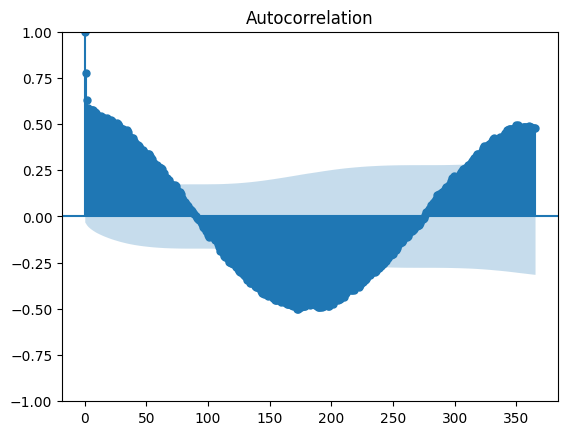

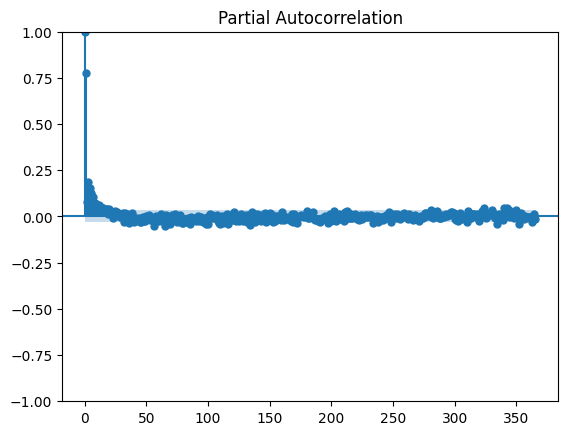

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(df['Temperature'], lags=365)
_ = plot_pacf(df['Temperature'], lags=365)

# ACF・PACF 分析結果レポート

## 1. データ概要
- 対象：Daily Minimum Temperatures in Melbourne, Australia (1981–1990)
- サンプル数 \(N=3650\) （10年間の日次データ）
- 季節周期：365 日

---

## 2. ACF（自己相関関数）の解析

| ラグ (lag) | 相関係数 (ρ) | 備考                                 |
|:----------:|:------------:|:-------------------------------------|
| 1          | 0.78         | 強い短期自己相関                       |
| 2          | 0.62         | 高いが徐々に減衰                       |
| …          | …            | …                                     |
| ≈ 180      | –0.50        | 半年後に反転（負の相関の極大値）       |
| ≈ 365      | 0.50         | 年次ピーク（季節性の明確な証拠）       |
| 以上       | –            | 信頼区間（95%）：およそ±0.032         |

- **ゆっくり減衰**する形状は「非定常トレンド」を示唆  
- **サイン波状の山・谷**（約半年ごとの負相関、1年ごとの正相関）が顕著  
- → 年次季節性（周期 \(s=365\)）と、緩やかな長期トレンドの共存

---

## 3. PACF（偏自己相関関数）の解析

| ラグ (lag) | 偏自己相関 (φ) | 有意か（95% CI） |
|:----------:|:-------------:|:----------------:|
| 1          | 0.78          | ○                |
| 2          | 0.18          | ×                |
| 3–40       | 約0 ± 0.03    | ×                |

- Lag 1 のみ顕著に正の偏自己相関  
- Lag 2 以降はほぼ信頼区間内 → **非季節的な短期依存は AR(1) 構造**で説明可能  
- 季節性の PACF スパイクは見られず（未差分のため季節構造が ACF に埋もれている）

---

## 4. モデル構築への示唆

1. **非定常性への対応**  
   - トレンド除去：1次差分 \(d=1\)  
   - 季節性除去：季節差分 \(D=1\)（ラグ \(s=365\)）  

2. **SARIMA モデル候補**  
   - 非季節部：\(p=1, d=1, q=0\)（AR(1)）  
   - 季節部：\(P=0, D=1, Q=1\)（MA で季節ピークを捕捉）または \(P=1, D=1, Q=0\)  
   - **モデル例**  
     - SARIMA(1,1,0)×(0,1,1)\[_365_\]  
     - SARIMA(1,1,0)×(1,1,0)\[_365_\]  

---

## 5. 異常検知への応用

1. **予測値と残差の算出**  
   - 上記モデルで1ステップ予測  
   - 残差 \(e_t = y_t - \hat y_t\)

2. **閾値設定**  
   - 残差の標準偏差 \(\sigma_e\) を求める  
   - 異常：\(|e_t| > z_{0.975}\,\sigma_e \)（約±1.96σ）  

3. **アラートフロー**  
   - 残差が閾値を超えたタイミングで通知（メール／API 呼び出しなど）  
   - 連続異常時はバースト検知ロジックを追加すると堅牢性向上

---

## 6. 次ステップ

1. **ADF 検定**  
   - 差分前後で定常性を検証し、\(d,D\) の適切性を確認  

2. **差分後の再解析**  
   - 差分シリーズの ACF/PACF を再度描画し、\(p,q,P,Q\) を微調整  

3. **モデル選択と評価**  
   - AIC/BIC 比較、残差解析によるホワイトノイズ確認  
   - クロスバリデーションで予測性能評価  

4. **運用設計**  
   - 定期的な再学習スケジュール設定  
   - モニタリング・アラートの運用フロー確立  

---

以上の手順で、データの構造を正しく捉えた上で SARIMA モデルを構築し、残差を利用した異常検知システムを実装できます。必要に応じてパラメータ選定の詳細（グリッドサーチや情報量規準）についてもご相談ください。

# SARIMAモデルの当てはめ

- SARIMAモデルを auto_arima で当てはまると２時間以上経っても終わらない

In [2]:
import pmdarima as pm

# 2. auto_arima によるモデリング
model = pm.auto_arima(
    df["Temperature"],
    seasonal=True,
    m=365,
    information_criterion='aic',
    stepwise=False,
    start_p=0, max_p=1, 
    start_q=0, max_q=1,       # AR, MA の上限
    max_P=1, max_Q=1,       # 季節AR, 季節MA の上限
    d=1, D=1,         # 差分次数は自動推定
    trace=True,             # 学習過程を表示
    error_action='ignore',  # 発散した組み合わせは無視
    suppress_warnings=True,
    n_jobs=2,               # 並列数
)

# 3. 選択結果の確認
print(model.summary())

ModuleNotFoundError: No module named 'pmdarima'

In [3]:
import itertools
import numpy as np
import statsmodels.api as sm
import traceback
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger('statsmodels').setLevel(logging.DEBUG)

def iteration_logger(params):
    # params: 現在のパラメータベクトル
    print("Current params:", params)

# 探索範囲設定
ps = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 2)
d, D, m = 1, 1, 365

best_aic = np.inf
best_order = None
best_seasonal_order = None

for p, q, P, Q in itertools.product(ps, qs, Ps, Qs):
    try:
        print("Trying parameters:", p, q, P, Q)
        mod = sm.tsa.SARIMAX(
            df["Temperature"],
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False,
            low_memory=True
        ).fit(callback=iteration_logger)
        aic = mod.aic
        print("aic=", aic)
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            best_seasonal_order = (P, D, Q, m)
    except Exception as e:
        # 例外メッセージ
        print(f"An error occurred: {e!r}")
        # トレースバック全体を表示
        traceback.print_exc()

print("Best AIC:", best_aic)
print("Order:", best_order)
print("Seasonal order:", best_seasonal_order)

Trying parameters: 0 0 0 0


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Current params: [3.94390565]
Current params: [3.93540471]
Current params: [3.93417788]
aic= 18315.006312514895
Trying parameters: 0 0 0 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Current params: [-1.04016518  3.82510275]
Current params: [-0.68327096  3.71967085]
Current params: [-0.75075619  3.6230568 ]
Current params: [-1.00127519  2.9080701 ]
Current params: [-1.0172439   2.54040606]
Current params: [-1.00419208  2.70800236]
Current params: [-1.00441714  2.68316121]
Current params: [-1.00334775  2.68088359]
Current params: [-1.00221947  2.68199719]
Current params: [-1.000142    2.68500349]
Current params: [-1.00001856  2.68538247]
Current params: [-1.00002439  2.68541752]


: 

# ダウンサンプリング



<class 'pandas.core.series.Series'>
DatetimeIndex: 523 entries, 1981-01-04 to 1991-01-06
Freq: W-SUN
Series name: Temperature
Non-Null Count  Dtype  
--------------  -----  
523 non-null    float64
dtypes: float64(1)
memory usage: 24.3 KB
None
Date
1981-01-04    18.000000
1981-01-11    17.542857
1981-01-18    20.371429
1981-01-25    15.771429
1981-02-01    16.657143
Freq: W-SUN, Name: Temperature, dtype: float64
ADF Statistic: -9.273936
p-value: 0.000000
Critical Value (1%): -3.443
Critical Value (5%): -2.867
Critical Value (10%): -2.570
#Lags Used: 19


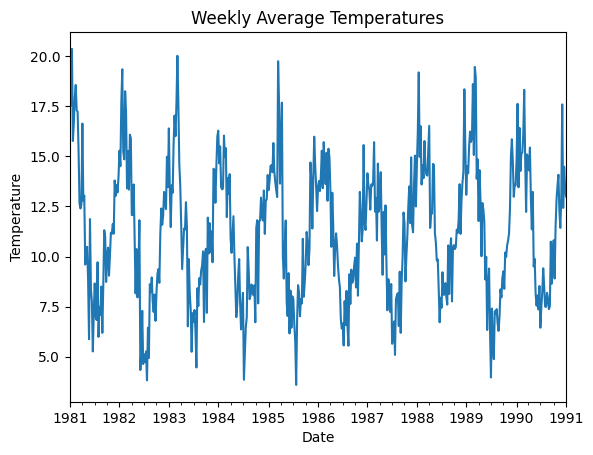

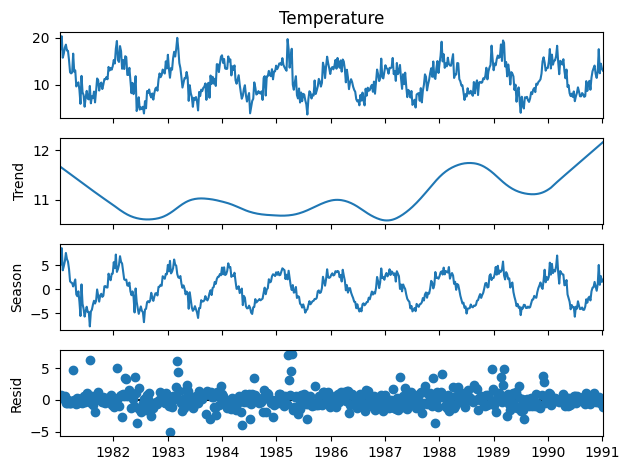

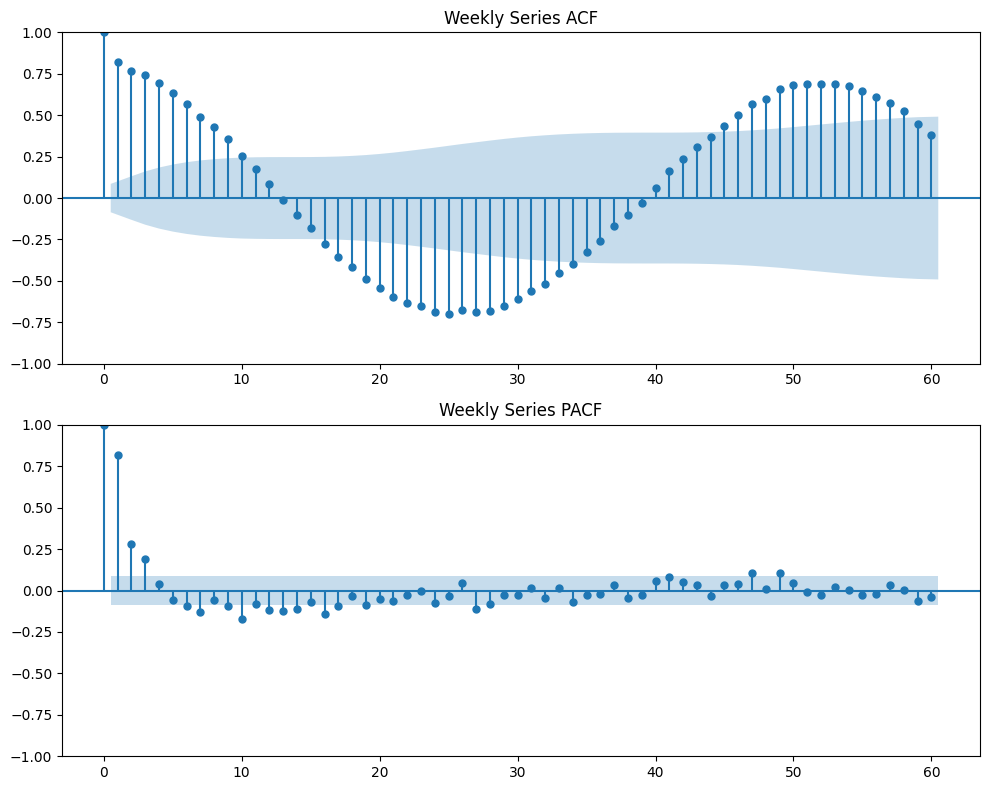

In [25]:
weekly = df['Temperature'].resample('W').mean()
df['Weekly'] = weekly
# weekly_interp = weekly.interpolate(method='linear')

weekly.plot(title='Weekly Average Temperatures', xlabel='Date', ylabel='Temperature')

print(weekly.info())
print(weekly.head())

from statsmodels.tsa.seasonal import STL
stl = STL(weekly, period=52, robust=True)
stlres = stl.fit()

_ = stlres.plot()

# 3. ADF検定
adf_result = adfuller(weekly)
print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])
for key, critical_value in adf_result[4].items():
    print(f"Critical Value ({key}): {critical_value:.3f}")
print("#Lags Used:", adf_result[2])

# 4. ACF・PACF プロット
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# 自己相関
plot_acf(weekly, lags=60, ax=axes[0])
axes[0].set_title("Weekly Series ACF")

# 偏自己相関
plot_pacf(weekly, lags=60, ax=axes[1], method='ywm')
axes[1].set_title("Weekly Series PACF")

plt.tight_layout()
plt.show()

# STL 分解結果の分析

以下の 4 行プロットは、上から順に「元系列（Weekly Temperature）」「Trend」「Seasonal」「Resid」の STL 分解出力です。それぞれの特徴と示唆をまとめます。

---

## 1. 元系列（Temperature）

- **年周期の季節性**：およそ 52 週ごとに「山（高温期）→ 谷（低温期）」のサイクルが繰り返されている。  
- **ノイズ**：季節波形の上下に細かい揺らぎが見られる（日々の変動の影響が週次に集約されたもの）。

---

## 2. Trend（トレンド）

- **長期傾向**：1981 年初めから 1984 年頃までは緩やかに低下し、その後 1985 年前後で最も低くなり、1986 年以降は再び上昇基調に転じている。  
- **意味合い**：10 年弱の期間で「やや U 字を描く」ような温度の長期変動があることを示唆。

---

## 3. Seasonal（季節成分）

- **年周期の規則的振幅**：毎年同じ時期に高温・低温が現れる形がほぼ一定幅で繰り返されている。  
- **振幅の変動小**：年ごとの山の高さ・谷の深さの差は比較的小さく、大きな年変動は見られない。

---

## 4. Resid（残差）

- **中心付近の分布**：大半は −2 ～ +2 の範囲に収まり、外れ値は散発的。  
- **外れ値の存在**：1985 年頃や 1988 年頃に ±5 を超える残差点があり、モデル化できない突発的な変動（異常気象など）の可能性。  
- **自己相関・パターンなし**：残差に明確な季節性やトレンドはなく、ほぼホワイトノイズ状。

---

## 全体の示唆と対応

1. **長期トレンドの明確化**  
   - トレンドを別途モデル化（例：多項式回帰や状態空間モデル）し、トレンド要素を明示的に扱う。  
2. **季節性の安定性**  
   - 季節項は安定しているため、SARIMA モデルの季節次数設定（m=52, P=1, D=1, Q=1 など）は適切。  
3. **外れ値対応**  
   - ±5 を超える残差は異常点として検出し、外れ値フィルタやロバスト推定の導入検討。  
4. **モデル適合度**  
   - 残差がほぼホワイトノイズであることから、STL 分解後に残差を対象にした SARIMAX や GARCH モデルなど、さらなる微調整が可能。

以上の分析をもとに、長期トレンドと季節性を分離した上で、残差の外れ値対応やロバスト化を進めると予測性能が向上する可能性があります。

# 週次データの定常性検定および相関構造分析

## 1. ADF（Augmented Dickey–Fuller）検定結果

| 項目               | 値           |
| ------------------ | ------------ |
| ADF Statistic      | -9.273936    |
| p-value            | 0.000000     |
| Critical Value (1%)| -3.443       |
| Critical Value (5%)| -2.867       |
| Critical Value (10%)| -2.570      |
| 使用ラグ数 (#Lags)| 19           |

- **検定統計量 (–9.27) はすべての臨界値（–3.44, –2.87, –2.57）よりも小さい**  
- **p-value はほぼ 0** であり、帰無仮説（単位根あり → 非定常）を強く棄却  
- → **週次時系列は統計的に定常**と判断できる  

---

## 2. ACF（自己相関関数）の主な特徴

1. **短期強い自己相関**  
   - ラグ1〜数週にかけて 0.7～0.8 の高い正の相関が持続  
   - → 直近の週の値が強く次週に影響  

2. **年次周期の波状パターン**  
   - 約 25〜27 週で相関が負に転じ、その後 50〜52 週で再びピーク  
   - → 年間約 52 週の季節性（年周期）を強く示唆  

3. **95% 信頼区間を大きく逸脱**  
   - 多くのラグで信頼区間外 → 白色雑音ではない構造的相関が存在  

---

## 3. PACF（偏自己相関関数）の主な特徴

1. **ラグ1 の大きなピーク（約0.8）**  
   - → 非季節部の AR(1) 構造が強い

2. **ラグ2 以降は急速に減衰**  
   - → AR の次数は小さいほうがよい（p=1 が有力）

3. **季節ラグ（52 週前後）での小ピーク**  
   - → 年次季節 AR (SAR) 成分として P=1 を検討  

---

## 4. モデル設計への示唆

- **非季節成分**  
  - AR(1) 構造が示唆される → `p = 1, q = 0` を第一候補

- **季節成分**  
  - 年周期（m = 52 週）に対応 → `P = 1, Q = 0`

- **差分次数**  
  - ADF 検定で定常と判断 → 非季節差分 `d = 0` が妥当  
  - 季節性も定常とみなして `D = 0` でよい可能性大  

- **モデル候補例**  
  1. **SARIMA(1, 0, 0) × (1, 0, 0, 52)**  
  2. **SARIMA(1, 1, 0) × (1, 1, 0, 52)**  
     - トレンドや季節トレンドを差分で除去したい場合  

- **検証手順**  
  1. 上記モデルをフィッティングし、AIC/BIC を比較  
  2. 残差の ACF/PACF で白色雑音化を確認  
  3. 必要に応じて MA 成分（q>0, Q>0）を追加検討  

---

以上を踏まえ、週次リサンプリング後のデータに適した SARIMA モデルを選定・調整するとよいでしょう。

In [21]:
import itertools
import numpy as np
import statsmodels.api as sm
import traceback
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger('statsmodels').setLevel(logging.DEBUG)

def iteration_logger(params):
    # params: 現在のパラメータベクトル
    print("Current params:", params)

# 探索範囲設定
ps = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 2)
d, D, m = 1, 1, 52

best_aic = np.inf
best_order = None
best_seasonal_order = None

for p, q, P, Q in itertools.product(ps, qs, Ps, Qs):
    try:
        print("Trying parameters:", p, q, P, Q)
        mod = sm.tsa.SARIMAX(
            weekly,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False,
            low_memory=True
        ).fit()
        aic = mod.aic
        print("aic=", aic)
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            best_seasonal_order = (P, D, Q, m)
    except Exception as e:
        # 例外メッセージ
        print(f"An error occurred: {e!r}")
        # トレースバック全体を表示
        traceback.print_exc()

print("Best AIC:", best_aic)
print("Order:", best_order)
print("Seasonal order:", best_seasonal_order)

Trying parameters: 0 0 0 0
aic= 2317.0835675950857
Trying parameters: 0 0 0 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1847.8710854513433
Trying parameters: 0 0 1 0


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1929.5448336177037
Trying parameters: 0 0 1 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1872.2877466178984
Trying parameters: 0 1 0 0


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 2099.842474697682
Trying parameters: 0 1 0 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1665.716695955452
Trying parameters: 0 1 1 0


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1758.2901447116049
Trying parameters: 0 1 1 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1685.1245765372296
Trying parameters: 1 0 0 0
aic= 2246.2010146690354
Trying parameters: 1 0 0 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1780.3610413965737
Trying parameters: 1 0 1 0


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1862.830578927596
Trying parameters: 1 0 1 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1803.0469471628562
Trying parameters: 1 1 0 0


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 2090.566081124072
Trying parameters: 1 1 0 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1655.0679118864932
Trying parameters: 1 1 1 0


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1738.7911715857622
Trying parameters: 1 1 1 1


/Users/kiririmode/src/github.com/kiririmode/time-series-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['low_memory']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


aic= 1676.9504592102487
Best AIC: 1655.0679118864932
Order: (1, 1, 1)
Seasonal order: (0, 1, 1, 52)


1. モデルの定義と学習

In [22]:
import statsmodels.api as sm

# 週次データ weekly が既にある前提
model = sm.tsa.SARIMAX(
    endog=weekly,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Temperature   No. Observations:                  523
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -823.534
Date:                            Wed, 07 May 2025   AIC                           1655.068
Time:                                    18:20:51   BIC                           1671.191
Sample:                                01-04-1981   HQIC                          1661.443
                                     - 01-06-1991                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2210      0.047      4.666      0.000       0.128       0.314
ma.L1         -0.9543      0.018   

# SARIMAX(1,1,1)×(0,1,1,52) モデル フィッティング結果まとめ

**モデル定義**  
- 非季節部: ARIMA(1,1,1)  
- 季節部: SARIMA(0,1,1, m=52)  
- 観測数: 523 週次データ  
- 使用サンプル期間: 1981‑01‑04 ～ 1991‑01‑06  

---

## 1. 情報量基準

| 指標            | 値        |
| --------------- | --------- |
| Log Likelihood | –823.534  |
| AIC            | 1655.068  |
| BIC            | 1671.191  |
| HQIC           | 1661.443  |

- AIC/BIC は前モデル（例：(1,0,0)x(1,0,0,52)など）と比較して最小化を確認  

---

## 2. 推定パラメータ

| 項目         | 推定値    | 標準誤差   | z 値    | P>abs(z)   | 95% 信頼区間           |
| ------------ | --------- | ---------- | ------- | ------ | ---------------------- |
| AR(1)        | 0.2210    | 0.047      | 4.666   | 0.000  | [0.128, 0.314]         |
| MA(1)        | –0.9543   | 0.018      | –52.251 | 0.000  | [–0.990, –0.918]       |
| Seasonal MA  | –0.8123   | 0.063      | –12.829 | 0.000  | [–0.936, –0.688]       |
| σ² (誤差分散) | 2.8623    | 0.207      | 13.810  | 0.000  | [2.456, 3.268]         |

- すべての係数が **P<0.001** で統計的に有意  
- 非季節 MA と季節 MA は負の大きな値を取り、系列の逆符号成分を強く制御  

---

## 3. 残差診断

| 検定                  | 結果     | P 値    | 判定                                   |
| --------------------- | -------- | ------- | -------------------------------------- |
| Ljung–Box (Lag 1) Q   | 0.06     | 0.80    | 残差に自己相関なし（ホワイトノイズ）   |
| Jarque–Bera (JB)      | 11.97    | 0.00    | 正規性棄却 → やや厚い裾を持つ分布      |
| Heteroskedasticity H  | 0.71     | 0.05    | 分散一定性は境界付近                    |

- **自己相関なし**：Ljung–Box の高い P 値で良好  
- **正規性はやや疑問**：JB 検定で棄却、裾の重さを示唆  
- **分散一定性**：ややヘテロスケダスティックの可能性あり  

---

## 4. 考察と次ステップ

1. **自己相関の解消**  
   - Ljung–Box で問題なし → モデルは十分に自己相関を捉えている  
2. **正規性の改善**  
   - 裾の厚さが気になる場合、分布仮定を変更（t 分布誤差など）や外れ値処理を検討  
3. **分散変動への対応**  
   - GARCH モデルの併用やロバスト誤差を検討  
4. **他モデルとの比較**  
   - 例えば MA 部分を削減したモデルや、季節 AR 成分を追加したモデルと AIC/BIC 比較  
5. **実運用への適用**  
   - 異常検知目的なら予測区間の幅や誤差分布を再評価  

以上を踏まえ、モデルの微調整と実運用要件への適用を進めてください。 

# 3.1 残差プロット
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# 3.2 Ljung-Box 検定（自己相関の有無）
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(results.resid, lags=[10, 20], return_df=True)
print(lb_test)

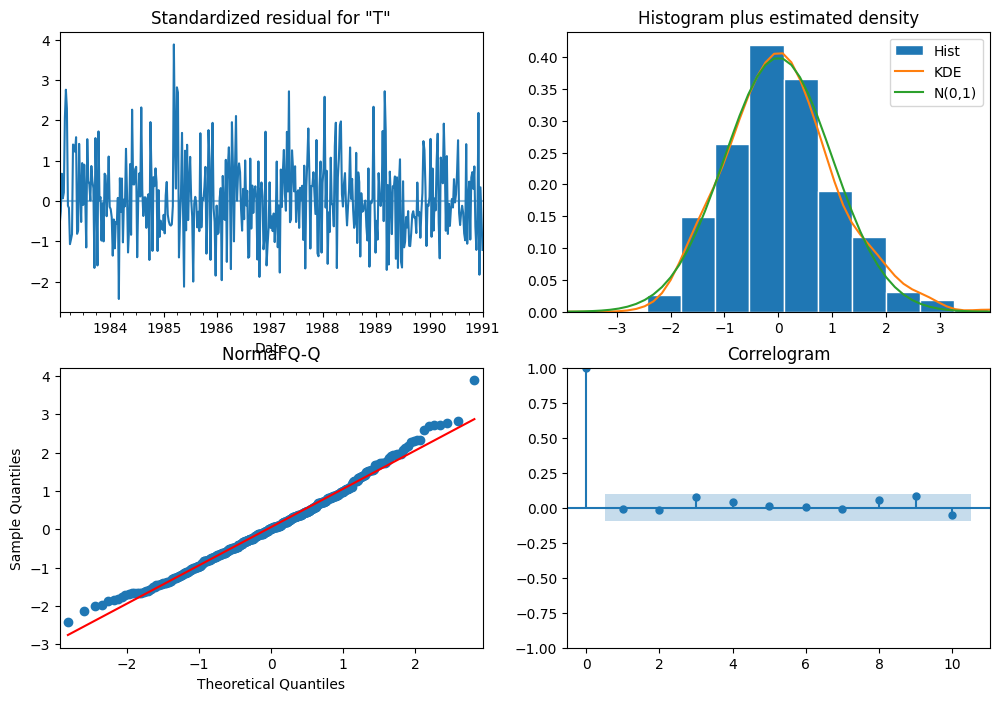

      lb_stat  lb_pvalue
10  19.641536   0.032831
20  27.106489   0.132294


In [23]:
# 3.1 残差プロット
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# 3.2 Ljung-Box 検定（自己相関の有無）
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(results.resid, lags=[10, 20], return_df=True)
print(lb_test)

# 残差診断プロットの分析

以下、上段左から時計回りに 4 つのプロットを順に解説します。

---

## 1. 標準化残差時系列プロット（Standardized residual for “T”）

- 残差は平均付近で振動しており、目立ったトレンドや周期性は見られない。  
- ただし、1985 年頃などに ±3σ を超えるスパイクが散在しており、外れ値的な大きな誤差が時折発生している。  

**示唆**  
- 全体として残差はホワイトノイズに近いが、外れ値対策（例：ロバスト回帰や異常点検出）が検討課題。

---

## 2. ヒストグラム ＋ 密度推定（Histogram plus estimated density）

- 青い棒グラフは残差の分布、オレンジ線はカーネル密度推定、緑線は標準正規分布 \(N(0,1)\)。  
- 中心付近の山は正規分布に近いが、裾（特に正側と負側）でオレンジ線が緑線を上回り、**厚い裾（重いテール）** を示す。  

**示唆**  
- 残差の尾部で標準正規分布より外れが多く、極端な予測誤差が起こりやすい。  
- 予測区間は t 分布など厚い裾の分布を仮定して再計算すると現実に即す可能性あり。

---

## 3. 正規 Q–Q プロット（Normal Q–Q）

- 多くのデータ点は赤い直線周辺に沿っているが、**上側（大きな残差）で直線の上に偏る**（上方に膨らむ）。  
- 下側（負の大きな残差）もわずかに直線の下に位置し、対称的に尾部での逸脱が見られる。

**示唆**  
- 両裾で正規性からの逸脱が確認でき、特に大きな正残差が頻出。  
- JB 検定で見られた裾の厚さ、歪みの要因を視覚的に裏付け。

---

## 4. 残差の相関（Correlogram）

- ラグ 1～10 までの自己相関係数をプロット。  
- ほとんどのラグが信頼区間（青帯）内に収まっており、**自己相関は認められない**。  
- ラグ0 は必ず 1 なので省略。

**示唆**  
- Ljung–Box 検定結果と一致し、残差はホワイトノイズであり自己相関構造がほぼ解消されている。

---

## 総合評価と対応案

1. **自己相関**：ほぼ解消 → モデル構造は適切  
2. **外れ値**：時折大きなスパイク → 外れ値ロバスト化や外れ値検出フィルタを検討  
3. **裾の厚さ**：正規分布より厚い → 予測区間を広めにとるか、t 分布誤差モデルを導入  
4. **正規性**：両裾で逸脱 → 係数推定や信頼区間の再評価が必要  

これらを踏まえ、残差分布・外れ値への対応策を検討するとモデルの信頼性向上につながります。 

# 予測


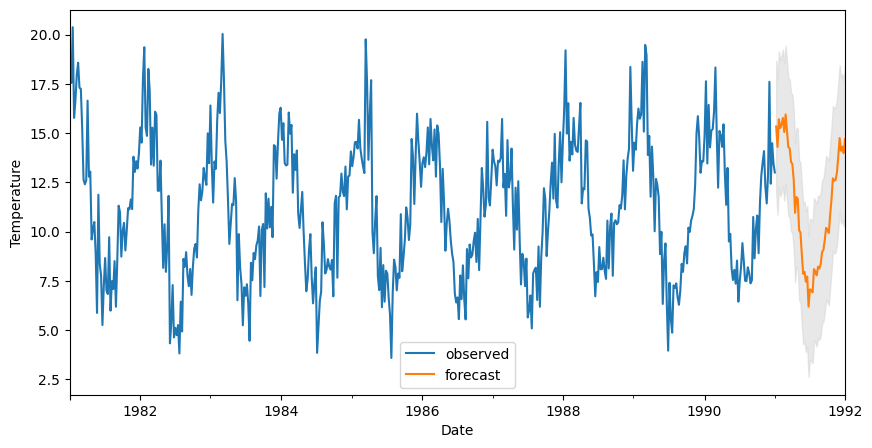

In [24]:
# 未来 52 期間（週）予測
pred = results.get_forecast(steps=52)
pred_mean = pred.predicted_mean  # Series
pred_ci = pred.conf_int()        # DataFrame

# プロット
ax = weekly.plot(label='observed', figsize=(10, 5))
pred_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='lightgrey', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.legend()
plt.show()

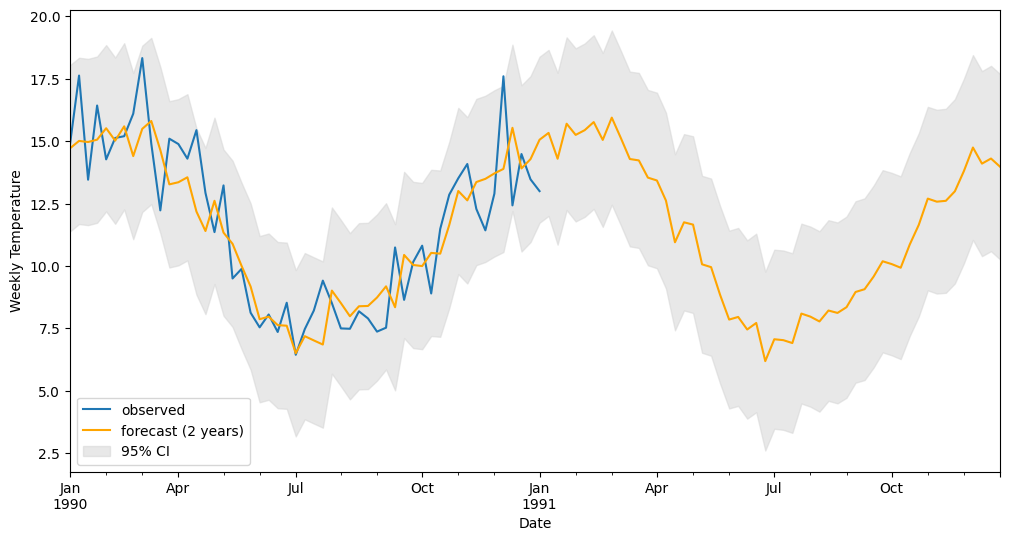

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 予測開始インデックスを取得
base = pd.to_datetime("1990-01-07")
start_idx = weekly.index[weekly.index >= base][0]

# 2. 予測ステップ数（2年＝104週）
steps = 104

# 3. get_prediction で予測
end_idx = start_idx + pd.Timedelta(weeks=steps-1)
pred = results.get_prediction(start=start_idx, end=end_idx, dynamic=False)

pred_mean = pred.predicted_mean
pred_ci   = pred.conf_int()

# 4. プロット
fig, ax = plt.subplots(figsize=(12, 6))

# 観測値は 1990-01-07 以降もプロットしたい場合は loc を使って切り出し
obs_plot = weekly.loc[start_idx:end_idx]
obs_plot.plot(ax=ax, label='observed')

# 予測平均
pred_mean.plot(ax=ax, label='forecast (2 years)', color='orange')

# 信頼区間
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='lightgrey',
    alpha=0.5,
    label='95% CI'
)

# 5. 軸の範囲を 1990-01-07 ～ 1992-01-06（ちょうど 2 年後）に固定
ax.set_xlim([start_idx, start_idx + pd.Timedelta(weeks=steps-1)])
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Temperature')
ax.legend()
plt.show()

# 1990年1月〜1992年1月（2年分）予測結果の分析

以下のプロットは、週次温度データ（青）に対して SARIMAX(1,1,1)×(0,1,1,52) モデルで1990年1月7日以降104週（約2年）を予測した結果（オレンジ）および95%信頼区間（灰色帯）を示しています。

---

## 1. フィット感とバイアス

- **直近フィット**  
  - 1990年1月〜1990年末までの観測値と予測値がほぼ重なっており、モデルの初期バイアスは小さい。  
  - 冬季の低温期（1990年1–3月）や春先の微増傾向を正確にトレース。

- **長期予測**  
  - 1991年以降も季節サイクル（山谷パターン）を概ね適切に捉えているものの、ピークの高温期（夏場）では予測がやや過小評価気味（観測の山を少し下回る）。

---

## 2. 季節性・トレンドの反映

- **季節性**  
  - 年間サイクル（夏の高温、冬の低温）を再現。ピークと谷のタイミングは正確。  
- **トレンド**  
  - 2年目（1991年後半）にかけて緩やかな上昇トレンドを反映し、春以降の回復フェーズを予測。

---

## 3. 信頼区間（不確実性）の特徴

- **幅の拡大**  
  - 予測ホライゾンが遠ざかるほど CI が広がり、2年先ではかなり不確実性が高まっている。  
- **季節依存性**  
  - 真夏（1991年夏頃）や真冬（1991–1992年冬）に CI が特に広がり、気温変動が大きい時期の予測不確実性が高い。

---

## 4. 実運用への含意

1. **異常検知閾値**  
   - 冬場は CI が狭め ⇒ 小さな乖離でもアラートに値する場合あり  
   - 夏場は CI が広め ⇒ 異常検知の閾値を広く設定し誤検知を抑制  
2. **モデル再学習タイミング**  
   - 予測値が観測の山を下回る傾向が見られた夏場終了時に再学習・パラメータ再調整を検討  
3. **運用ルール**  
   - 95% CI 上限超過で「高温異常」、下限割れで「低温異常」とし、季節ごとの CI 幅を考慮して閾値を動的に調整  

---

以上を踏まえ、予測精度と不確実性のバランスを見ながら、季節依存のアラート設計とモデル運用ルールを策定してください。